<a href="https://colab.research.google.com/github/ChetanAIML/Capstone/blob/main/Human_Face_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense,Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


# EDA

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
image_name    0
width         0
height        0
x0            0
y0            0
x1            0
y1            0
dtype: int64
             width       height           x0           y0           x1  \
count  3350.000000  3350.000000  3350.000000  3350.000000  3350.000000   
mean    967.967164   829.165373   367.840597   152.120896   614.433134   
std     651.959869   604.168252   322.675542   171.743790   451.800098   
min     150.000000   115.000000     1.000000     1.000000    49.000000   
25%     612.000000   433.000000   167.000000    52.000000   340.000000   
50%     800.000000   683.000000   294.000000   104.000000   506.000000   
75%    1200.000000  1024.000000   474.750000   197.000000   773.000000   
max    8192.000000  6680.000000  5212.000000  2375.000000  6815.000000   

                y1  
count  3350.000000  
mean    390.987761  
std     314.3781

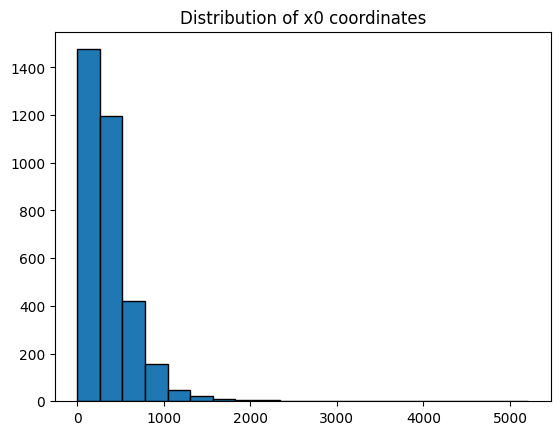

In [ ]:

from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/Shareddrives/Project/Capstone/'

# Step 1: Exploratory Data Analysis (EDA)



# Load the CSV file containing facial bounding box coordinates
df = pd.read_csv(path+'faces.csv')

# Check for missing values
print(df.isnull().sum())

# Descriptive statistics of bounding box coordinates
print(df.describe())

# Visualize the distribution of bounding box coordinates
plt.hist(df['x0'], bins=20, edgecolor='black')
plt.title('Distribution of x0 coordinates')
plt.show()


In [ ]:
df

image_name  width  height   x0   y0    x1   y1
0     00001722.jpg   1333    2000  490  320   687  664
1     00001044.jpg   2000    1333  791  119  1200  436
2     00001050.jpg    667    1000  304  155   407  331
3     00001736.jpg    626     417  147   14   519  303
4     00003121.jpg    626     418  462   60   599  166
...            ...    ...     ...  ...  ...   ...  ...
3345  00002232.jpg    620     349    4   36   186  158
3346  00002232.jpg    620     349  122  103   344  248
3347  00002232.jpg    620     349  258  118   541  303
3348  00002232.jpg    620     349  215   11   362  108
3349  00002232.jpg    620     349  330    1   487   81

[3350 rows x 7 columns]

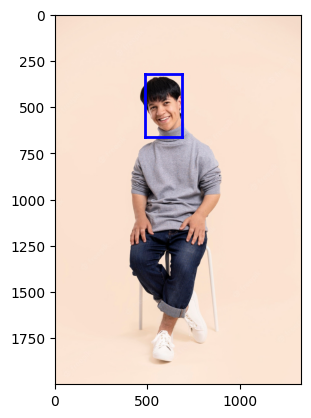

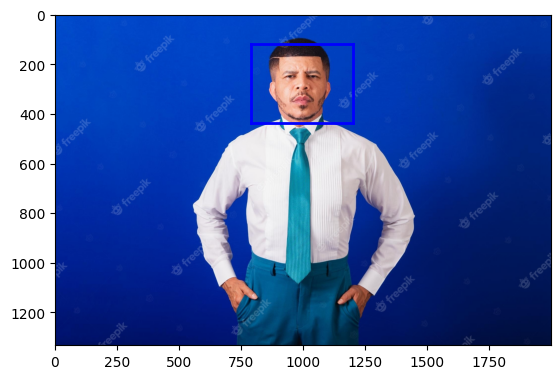

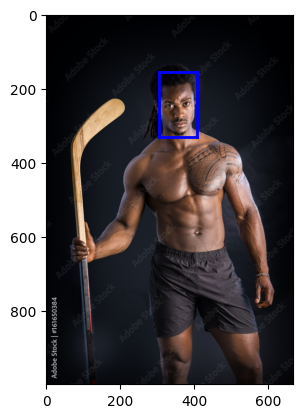

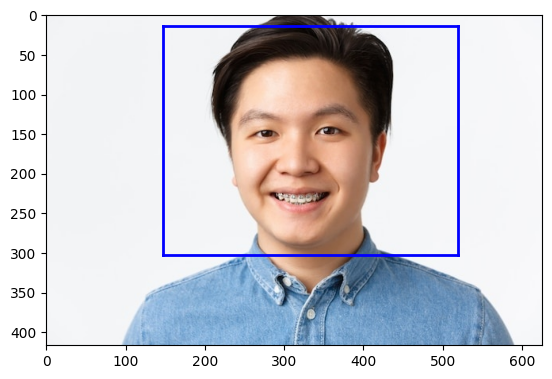

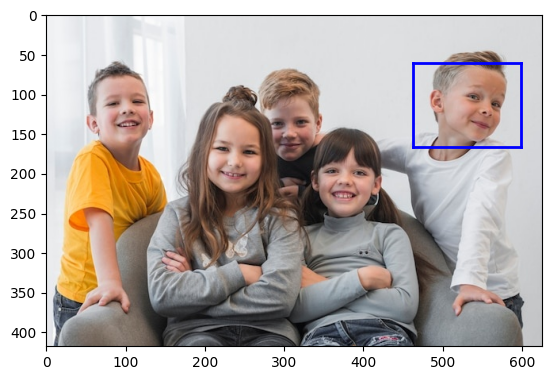

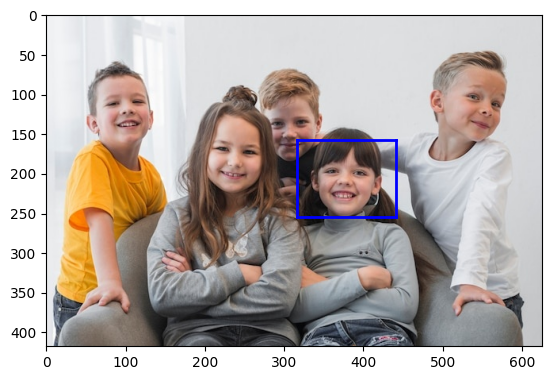

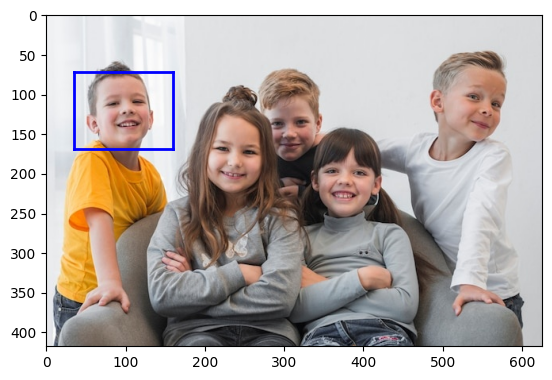

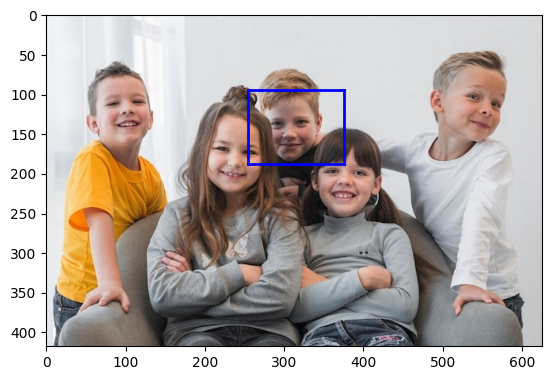

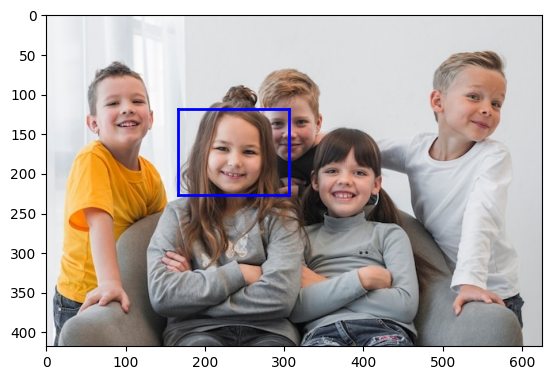

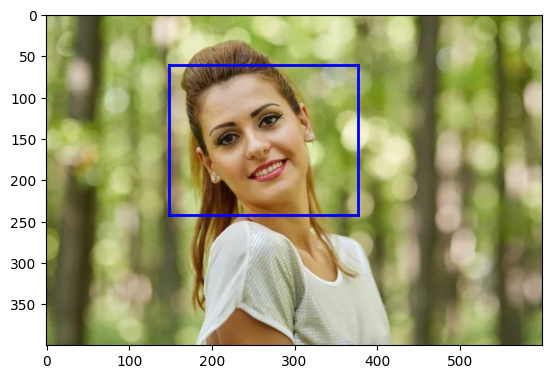

In [ ]:

# Visualize images with bounding boxes
for i in range(10):
    image_path = path+'images/' + df.loc[i, 'image_name']
    image = plt.imread(image_path)
    x0, y0, x1, y1 = df.loc[i, ['x0', 'y0', 'x1', 'y1']]
    plt.imshow(image)
    plt.plot([x0, x1], [y0, y0], 'b-', linewidth=2)
    plt.plot([x0, x0], [y0, y1], 'b-', linewidth=2)
    plt.plot([x1, x1], [y0, y1], 'b-', linewidth=2)
    plt.plot([x0, x1], [y1, y1], 'b-', linewidth=2)
    plt.show()

In [ ]:
data = {}
for i in df["image_name"]:
    if i not in data:
       data[i] = []

for index, img_name in enumerate(df["image_name"]):
        width = df["width"][index]
        height = df["height"][index]

        # print( 'actual width ' , width_actual , 'height ' , height_actual)
        # print( 'width ' , width , 'height ' , height)

        x0 = df["x0"][index]
        x1 = df["x1"][index]
        y0 = df["y0"][index]
        y1 = df["y1"][index]

        scaling_factor_width = 224 / width
        scaling_factor_height = 224 / height

        # Adjust the coordinates of the bounding box
        new_x0 = int(x0 * scaling_factor_width)
        new_y0 = int(y0 * scaling_factor_height)
        new_x1 = int(x1 * scaling_factor_width)
        new_y1 = int(y1 * scaling_factor_height)

        data[img_name].append(np.asarray([new_x0,new_x1, new_y0 , new_y1]))



In [ ]:
import cv2 as cv
images = []
for i in data.keys():
    img_arr = cv.imread(path+ 'images/' + i,cv.IMREAD_GRAYSCALE)
    img_resize = cv.resize(img_arr, (224, 224))
    images.append(img_resize)

In [ ]:
images = np.array(images)
images = np.expand_dims(images, axis = 3)

In [ ]:
print(f"Shape of images : {images.shape}")

Shape of images : (2204, 224, 224, 1)


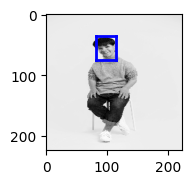

<ipython-input-10-6f7cfcda8911>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, i+1)


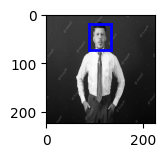

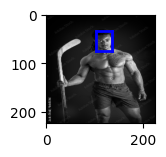

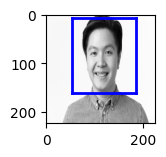

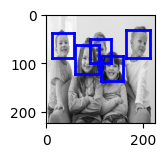

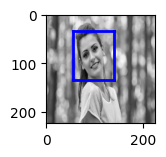

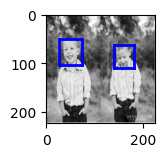

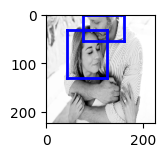

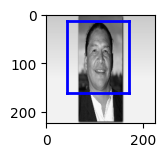

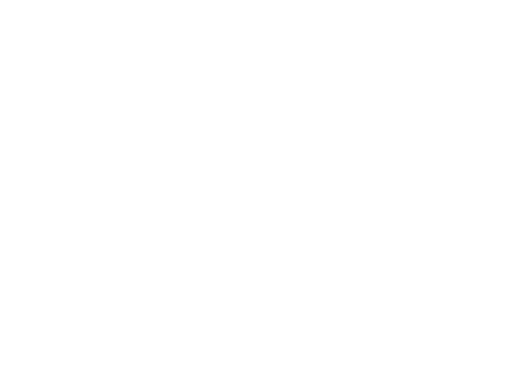

In [ ]:
plt.figure(figsize = (8,6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i], cmap = 'gray')
    for i in list(data.items())[i][1]:
        x0,x1,y0,y1 = i
        plt.plot([x0, x1], [y0, y0], 'b-', linewidth=2)
        plt.plot([x0, x0], [y0, y1], 'b-', linewidth=2)
        plt.plot([x1, x1], [y0, y1], 'b-', linewidth=2)
        plt.plot([x0, x1], [y1, y1], 'b-', linewidth=2)
    plt.show()
    plt.axis('off')

In [ ]:
bbox = []
for box in data.keys():
    bbox.append(data[box])

In [ ]:
max_bbox = 0
for i in range(len(bbox)):
    max_bbox = max(max_bbox, len(bbox[i]))

In [ ]:
for i in range(len(bbox)):
    if len(bbox[i]) <  int(max_bbox):
            empty_faces = np.zeros((max_bbox - len(bbox[i]), 4))
            bbox[i] = np.concatenate((bbox[i], empty_faces))



In [ ]:
bbox = np.array(bbox)

In [ ]:
images = images/255
bbox = bbox/224

In [ ]:
bbox.shape

flatten_bbox =[]
for i in range(len(bbox)):
  flatten_bbox.append(bbox[i].flatten())

In [ ]:
len(flatten_bbox)
flatten_bbox = np.array(flatten_bbox)
flatten_bbox.shape

(2204, 48)

# Helper Functions

In [ ]:
# Adapted from Daniel Bourke's Course on TensorFlow and Deep Learning
def plot_loss_curves(history):
  '''
  Returns separate loss curves for training and validation metrics
  '''
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['mae']
  val_accuracy = history.history['val_mae']

  epochs = range(len(history.history['loss'])) #generates the sequence of indices in a list, in this case epochs

  #Plot loss
  plt.plot(epochs, loss, label = 'training loss')
  plt.plot(epochs, val_loss, label = 'val_loss')
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = 'training mae')
  plt.plot(epochs, val_accuracy, label = 'val_mae')
  plt.title('MAE')
  plt.xlabel('MAE')
  plt.legend()

In [ ]:
def predict_face(image_path, model):
    # Load the image
    images =[]
    img_arr = cv.imread(image_path,cv.IMREAD_GRAYSCALE)
    img_resize = cv.resize(img_arr, (224, 224))
    images.append(img_resize)
    images = np.array(images)
    images = np.expand_dims(images, axis = -1)
    # Preprocess the image
    #image = normalize_image(image_raw)

    images = images/255

    prediction = model.predict(images)
    fig, ax = plt.subplots(1)
    ax.imshow(img_resize)
    x0 = int(prediction[0][0]*224)
    x1 = int(prediction[0][1]*224)
    y0 = int(prediction[0][2]*224)
    y1 = int(prediction[0][3]*224)


    x2 = int(prediction[0][4]*224)
    x3 = int(prediction[0][5]*224)
    y2 = int(prediction[0][6]*224)
    y3 = int(prediction[0][7]*224)

    plt.plot([x0, x1], [y0, y0], 'b-', linewidth=2)
    plt.plot([x0, x0], [y0, y1], 'b-', linewidth=2)
    plt.plot([x1, x1], [y0, y1], 'b-', linewidth=2)
    plt.plot([x0, x1], [y1, y1], 'b-', linewidth=2)

    # plt.plot([x2, x3], [y2, y2], 'b-', linewidth=2)
    # plt.plot([x2, x2], [y2, y3], 'b-', linewidth=2)
    # plt.plot([x3, x3], [y2, y3], 'b-', linewidth=2)
    # plt.plot([x2, x3], [y3, y3], 'b-', linewidth=2)
    # print(x0,y0, x1,y1, x2,y2,x3,y3)
    plt.show()

# Models

## Model 1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, flatten_bbox, test_size = 0.25, random_state = 42)

In [ ]:
class obj_detect_callback(keras.callbacks.Callback):
    def epoch_end(self, epoch, logs = {}):
        prediction = model.predict(X_test[0].reshape(1,224,224,1))
        fig, ax = plt.subplots(1)
        ax.imshow(X_test[0])
        x1 = int(prediction[0][0]*224)
        y1 = int(prediction[0][1]*224)
        x2 = int(prediction[0][2]*224)
        y2 = int(prediction[0][3]*224)
        rect = matplotlib.patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth = 1, edgecolor = 'r', facecolor = 'none')
        ax.add_patch(rect)
        plt.show()

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model_1 = Sequential([
    Conv2D(32, 3, input_shape = (224,224,1), padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(64, 3, padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(128, 3, padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(256, 3, padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(48, activation = 'sigmoid') #output layer has 48 neurons to match the bbox dimensions
])

# Step 3: Compile and train the model
model_1.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])


# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history_1 = model_1.fit(X_train, y_train,
                    validation_data = (X_test, y_test), epochs = 50, callbacks =early_stopping)

model_1.evaluate(X_test, y_test, batch_size = 32)

Epoch 1/50
52/52 [==============================] - 280s 5s/step - loss: 0.3367 - accuracy: 0.3642 - val_loss: 0.1445 - val_accuracy: 0.7441
Epoch 2/50
52/52 [==============================] - 278s 5s/step - loss: 0.1361 - accuracy: 0.7489 - val_loss: 0.1340 - val_accuracy: 0.7441
Epoch 3/50
52/52 [==============================] - 282s 5s/step - loss: 0.1295 - accuracy: 0.7489 - val_loss: 0.1310 - val_accuracy: 0.7441
Epoch 4/50
52/52 [==============================] - 275s 5s/step - loss: 0.1294 - accuracy: 0.7489 - val_loss: 0.1347 - val_accuracy: 0.7441
Epoch 5/50
52/52 [==============================] - 282s 5s/step - loss: 0.1306 - accuracy: 0.7489 - val_loss: 0.1307 - val_accuracy: 0.7441
Epoch 6/50
52/52 [==============================] - 275s 5s/step - loss: 0.1299 - accuracy: 0.7489 - val_loss: 0.1304 - val_accuracy: 0.7441


## Model 2

In [ ]:
model_2 = Sequential([
    Conv2D(32, 3, input_shape = (224,224,1), activation = 'relu'),
    Dropout(0.1),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(64, 3, activation = 'relu'),
    Dropout(0.2),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(128, 3, activation = 'relu'),
    Dropout(0.3),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(256, 3, activation = 'relu'),
    Dropout(0.4),
    MaxPool2D(pool_size = 2),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu'),
    Dense(48, activation = 'linear') #output layer
])



model_2.compile(loss = 'mean_squared_error',
               optimizer= tf.keras.optimizers.Adam(),
               metrics = ['mae'])

history_2 = model_2.fit(X_train, y_train, validation_data = (X_test, y_test),
           batch_size = 8, epochs = 60, callbacks = early_stopping)

model_2.evaluate(X_test, y_test, batch_size = 32)

Epoch 1/60
207/207 [==============================] - 311s 1s/step - loss: 0.0209 - mae: 0.0913 - val_loss: 0.0195 - val_mae: 0.0957
Epoch 2/60
207/207 [==============================] - 285s 1s/step - loss: 0.0125 - mae: 0.0637 - val_loss: 0.0170 - val_mae: 0.0846
Epoch 3/60
207/207 [==============================] - 287s 1s/step - loss: 0.0108 - mae: 0.0550 - val_loss: 0.0143 - val_mae: 0.0799
Epoch 4/60
207/207 [==============================] - 289s 1s/step - loss: 0.0104 - mae: 0.0516 - val_loss: 0.0135 - val_mae: 0.0736
Epoch 5/60
207/207 [==============================] - 290s 1s/step - loss: 0.0098 - mae: 0.0476 - val_loss: 0.0128 - val_mae: 0.0662
Epoch 6/60
207/207 [==============================] - 288s 1s/step - loss: 0.0094 - mae: 0.0448 - val_loss: 0.0116 - val_mae: 0.0538
Epoch 7/60
207/207 [==============================] - 287s 1s/step - loss: 0.0092 - mae: 0.0430 - val_loss: 0.0125 - val_mae: 0.0524
Epoch 8/60
207/207 [==============================] - 289s 1s/step - 

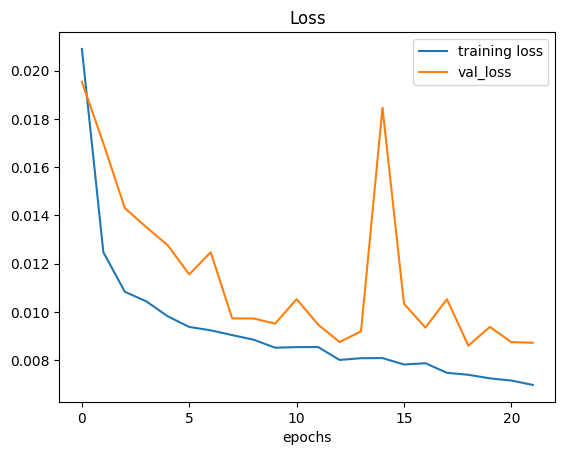

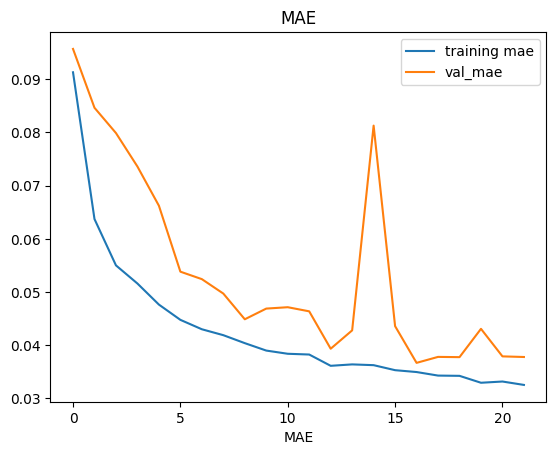

In [ ]:
plot_loss_curves(history_2)

## Model 3

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model_3 = Sequential([
    Conv2D(32, 3, input_shape = (224,224,1), padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(64, 3, padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(128, 3, padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    Conv2D(256, 3, padding = "same", activation = "relu"),
    MaxPool2D(pool_size = 2),
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(48, activation = 'linear') #output layer has 48 neurons to match the bbox dimensions
])

# Step 3: Compile and train the model
# Compile the model
model_3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

history_3 = model_3.fit(X_train, y_train,
                    validation_data = (X_test, y_test), epochs = 50, callbacks =early_stopping)

Epoch 1/50
52/52 [==============================] - 276s 5s/step - loss: 0.0146 - mae: 0.0601 - val_loss: 0.0116 - val_mae: 0.0516
Epoch 2/50
52/52 [==============================] - 277s 5s/step - loss: 0.0112 - mae: 0.0462 - val_loss: 0.0113 - val_mae: 0.0432
Epoch 3/50
52/52 [==============================] - 281s 5s/step - loss: 0.0111 - mae: 0.0455 - val_loss: 0.0117 - val_mae: 0.0510
Epoch 4/50
52/52 [==============================] - 286s 6s/step - loss: 0.0110 - mae: 0.0460 - val_loss: 0.0111 - val_mae: 0.0465
Epoch 5/50
52/52 [==============================] - 276s 5s/step - loss: 0.0107 - mae: 0.0458 - val_loss: 0.0111 - val_mae: 0.0502
Epoch 6/50
52/52 [==============================] - 276s 5s/step - loss: 0.0105 - mae: 0.0436 - val_loss: 0.0107 - val_mae: 0.0476
Epoch 7/50
52/52 [==============================] - 277s 5s/step - loss: 0.0100 - mae: 0.0425 - val_loss: 0.0112 - val_mae: 0.0531


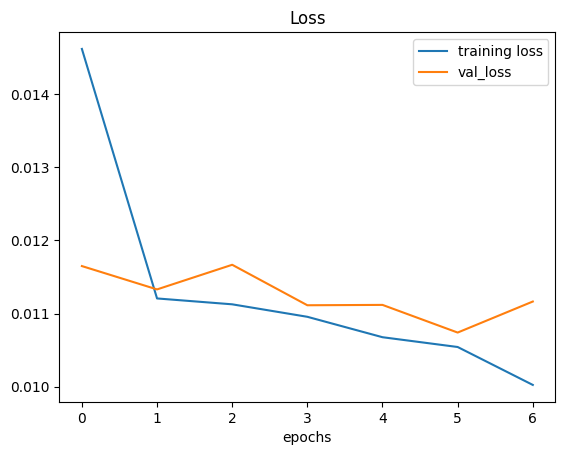

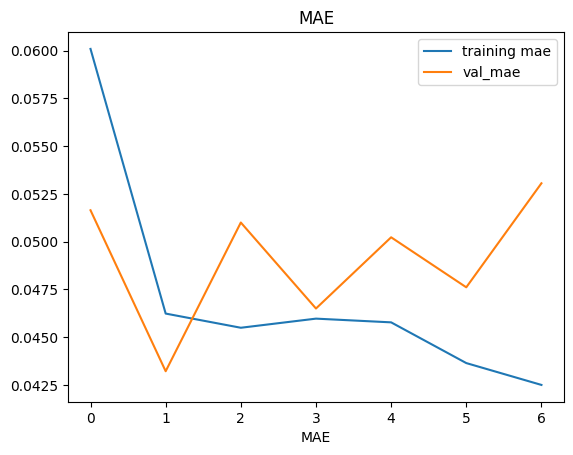

In [ ]:
plot_loss_curves(history_3)

# Predictions

1/1 [==============================] - 0s 61ms/step


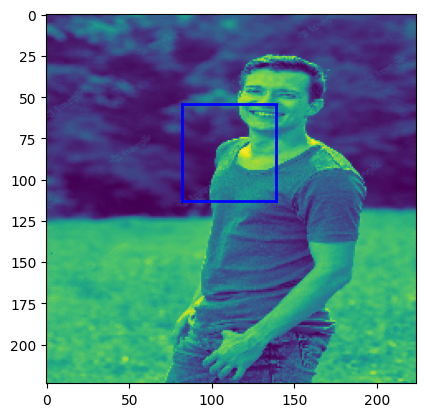

In [ ]:
predict_face('test.jpg',model)

1/1 [==============================] - 0s 339ms/step


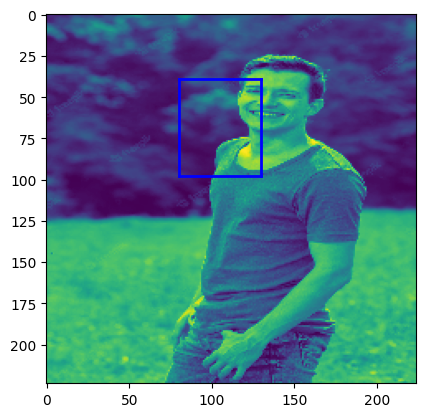

In [ ]:
predict_face('test.jpg',model_2)

1/1 [==============================] - 0s 90ms/step


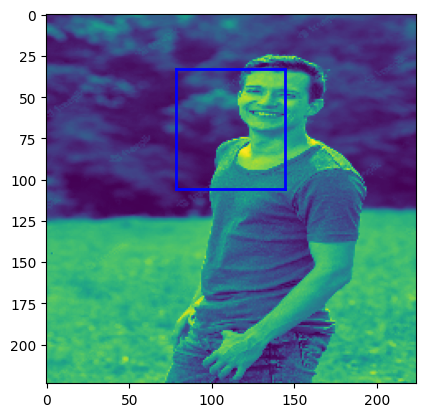

In [ ]:
predict_face('test.jpg',model_3)

1/1 [==============================] - 0s 51ms/step


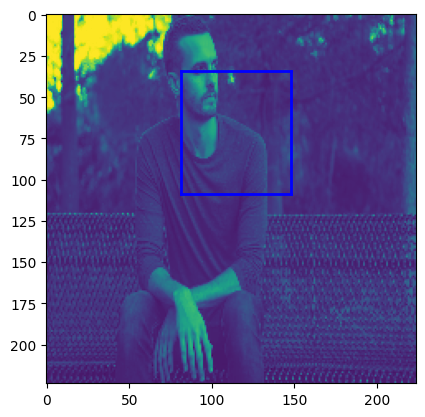

In [ ]:
predict_face('test3.jpg',model_3)

1/1 [==============================] - 0s 77ms/step


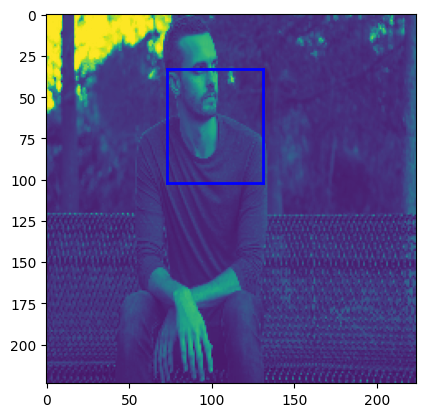

In [ ]:
predict_face('test3.jpg',model_2)